# Homework 02
## Basic Goal
Represent digits '3' in 2D.  
* convert data from the UCI [Optical Recognition of Handwritten Digits Data Set](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits)
* perform PCA over all digit '3' with 2 components
* plot the PCA results as below (also in page #12 of PCA )
## Requirements
* Programming lanuage: python3
* Optional package: tensorflow web or pytorch
* Plot the results in matplotlib Introduction in Chinese Tutorial

## PCA
We use pytorch 1.12+ package for this homework, please download the following requirements:

In [ ]:
!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

Convert data from the original dataset and represent digits '3' in 2D.

In [2]:
def read_ori_data(file):
    dataset = []
    f = open(file, encoding='utf-8')
    for i in range(21):
        f.readline()
    while True:
        s = f.readline().strip()
        if not s:
            break
        for i in range(31):
            s += f.readline().strip()
        label = int(f.readline().strip())
        dataset.append((torch.tensor(list(map(int, s))), label))
    return dataset

def get_data_with_label(dataset, label):
    three = []

    for i in dataset:
        if i[1] in label:
            three.append(torch.unsqueeze(i[0], dim=0))

    for i in range(len(three)):
        if i == 0:
            data = three[i]
        else:
            data = torch.cat((data, three[i]), dim=0)
    
    return data.clone().detach().float()

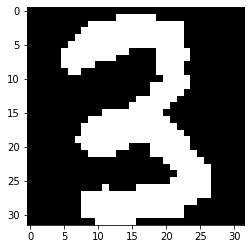

In [3]:
# Convert from original dataset
train_dataset = read_ori_data('data/optdigits-orig.tra')
data = get_data_with_label(train_dataset, [3])

# Display a sample of number 3
plt.imshow(data[0].reshape(32, -1), cmap='gray')
plt.show()

Do PCA with 2 components.

C:\Users\10527\AppData\Local\Temp/ipykernel_2112/2441365256.py:10: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Copy.cpp:250.)
  w, U = w.clone().detach().float(), U.clone().detach().float()   # ComplexFloat to Float


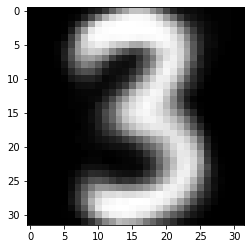

In [4]:
def pca2(data):
    """PCA with 2 components
    return: Xm, V2, m
    """
    m = data.mean(axis=0, keepdims=True)
    X = (data - m).T 

    H = X.T @ X 
    w, U = torch.linalg.eig(H)
    w, U = w.clone().detach().float(), U.clone().detach().float()   # ComplexFloat to Float
    D = torch.diag(torch.sqrt(w))
    V = (torch.linalg.inv(U @ D) @ X.T).T

    Y = V[:, :2]       # Select 2 principle components
    Xm = Y.T @ X

    return Xm, Y, m    # for visualization

# PCA 
Xm, Y, m = pca2(data)

# Display eigen (mean) image
plt.imshow((Y @ Xm + m.T)[:, 0].reshape(32, 32), cmap='gray')
plt.show()

Plot PCA results.

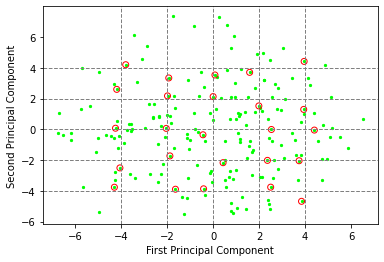

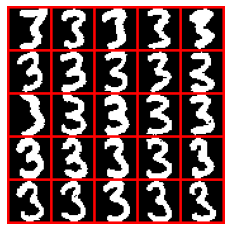

In [5]:
def get_focus(x, y, axv, axh):
    focus = []
    for v in axv:
        for h in axh:
            best = 0
            for i in range(int(list(x.size())[0])):
                if pow((x[i] - v), 2) + pow((y[i] - h), 2) < pow((x[best] - v), 2) + pow((y[best] - h), 2):
                    best = i
            focus.append(best)
    return focus

def vis_2_comp(data, x, y, axv, axh, focus, method='pca', plot=True):
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')   
    for v in axv:
        plt.axvline(x=v,color="grey",ls="--",lw=1)
    for h in axh:
        plt.axhline(y=h,color="grey",ls="--",lw=1)
    # print(x, y)
    plt.scatter(x, y, color='lime', s=5)
    
    fx, fy = [x[i] for i in focus], [y[i] for i in focus]
    plt.scatter(fx, fy, color='none', marker='o', edgecolor='red')
    if plot:
        plt.savefig("img/"+method+"_scatter.png")
    plt.show()

    padding = 2
    L = 32 * 5 + padding * 6
    canvas = np.zeros((L, L, 3))
    canvas[:, :, 0] = np.ones((L, L))

    for i in range(5):
        x = padding * (i + 1) + i * 32
        for j in range(5):
            y = padding * (j + 1) + j * 32
            img = data[focus[i * 5 + j]].reshape(32, 32)
            img = np.stack((img, img, img), axis=-1)
            canvas[x: x + 32, y: y + 32] = img
            
    plt.axis('off')
    plt.imshow(canvas)
    if plot:
        plt.savefig("img/"+method+"_eigen.png")
    plt.show()

# Plot PCA result
axv = np.linspace(-4, 4, 5, endpoint=True)
axh = np.linspace(-4, 4, 5, endpoint=True)
focus = get_focus(Xm[0], Xm[1], axv, axh)
vis_2_comp(data, Xm[0], Xm[1], axv, axh, focus, method='pca', plot=True)

## Adavanced Goal
Implement t-SNE or UMAP for the visualization part.  
In this part, I choose to use t-SNE method.

In [10]:
def Hbeta(D, beta=1.0):
    P = torch.exp(-D.clone() * beta)

    sumP = torch.sum(P)

    H = torch.log(sumP) + beta * torch.sum(D * P) / sumP
    P = P / sumP

    return H, P

def pji(X, tol=1e-15, perp=30.0):
    n, d = X.shape

    D = torch.add(torch.add(-2 * torch.mm(X, X.t()), torch.sum(X*X, 1)).t(), torch.sum(X*X, 1))
    P = torch.zeros(n, n)

    beta = torch.ones(n, 1)
    logU = torch.log(torch.tensor([perp]))

    n_list = [i for i in range(n)]

    for i in range(n):

        # Compute the Gaussian kernel and entropy for the current precision
        # there may be something wrong with this setting None
        betamin = None
        betamax = None
        Di = D[i, n_list[0:i]+n_list[i+1:n]]

        H, thisP = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while torch.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].clone()
                if betamax is None:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].clone()
                if betamin is None:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            H, thisP = Hbeta(Di, beta[i])

            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, n_list[0:i]+n_list[i+1:n]] = thisP

    print("Mean value of sigma: %f" % torch.mean(torch.sqrt(1 / beta)))
    # Return final P-matrix
    return P

def pca(X, dims=50):
    print("Preprocessing the data using PCA...")
    n, d = X.shape
    X = X - torch.mean(X, 0)

    l, M = torch.linalg.eig(torch.mm(X.t(), X))
    l, M = l.clone().detach().float(), M.clone().detach().float()

    Y = torch.mm(X, M[:, 0:dims])
    return Y


def tsne(X, dims=2, initial_dims=50, perp=30.0, max_iter=1000):

    # Initialize variables
    X = pca(X, initial_dims)
    n, d = X.shape

    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = torch.randn(n, dims)
    dY = torch.zeros(n, dims)
    iY = torch.zeros(n, dims)
    gains = torch.ones(n, dims)

    # Compute P-values
    P = pji(X, 1e-5, perp)
    P = P + P.t()
    P = P / torch.sum(P)
    P = P * 4.    # early exaggeration
    print("get P shape", P.shape)
    P = torch.max(P, torch.tensor([1e-21]))

    loss_list = []
    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = torch.sum(Y*Y, 1)
        num = -2. * torch.mm(Y, Y.t())
        num = 1. / (1. + torch.add(torch.add(num, sum_Y).t(), sum_Y))
        # num[range(n), range(n)] = 0.
        num[torch.eye(n, n, dtype=torch.long) == 1] = 0.
        Q = num / torch.sum(num)
        Q = torch.max(Q, torch.tensor([1e-12]))

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = torch.sum((PQ[:, i] * num[:, i]).repeat(dims, 1).t() * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum

        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)).double() + (gains * 0.8) * ((dY > 0.) == (iY > 0.)).double()
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - torch.mean(Y, 0)

        loss = torch.sum(P * torch.log(P / Q))
        loss_list.append(loss)

        if (iter + 1) % 100 == 0:
            print("Iteration %d: loss = %f" % (iter + 1, loss))

        # Stop exaggeration
        if iter == 100:
            P = P / 4.

    plt.plot(loss_list)
    plt.show()
    return Y

Preprocessing the data using PCA...
Mean value of sigma: 3.231037
get P shape torch.Size([199, 199])
Iteration 100: loss = 13.680913
Iteration 200: loss = 0.819341
Iteration 300: loss = 0.751487
Iteration 400: loss = 0.730420
Iteration 500: loss = 0.730415
Iteration 600: loss = 0.730415
Iteration 700: loss = 0.730415
Iteration 800: loss = 0.730415
Iteration 900: loss = 0.730415
Iteration 1000: loss = 0.730415


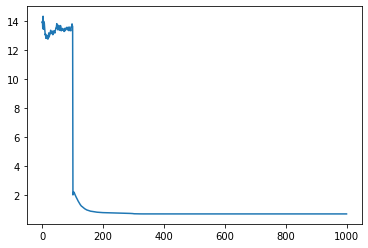

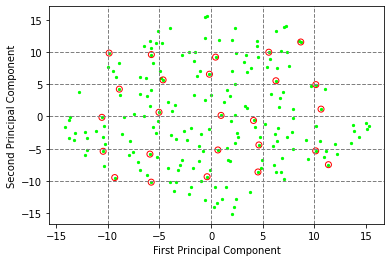

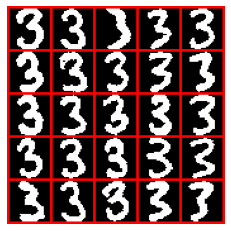

In [11]:
with torch.no_grad():
    Y = tsne(data, 2, 10, 30.0, 1000)
    # Y = tsne(data, 2, 50, 20.0, 1000)

axv = np.linspace(-10, 10, 5, endpoint=True)
axh = np.linspace(-10, 10, 5, endpoint=True)
focus = get_focus(Y[:, 0], Y[:, 1], axv, axh)
vis_2_comp(data, Y[:, 0], Y[:, 1], axv, axh, focus, method='tsne', plot=True)